<a href="https://colab.research.google.com/github/shaking54/CS114.K21.KHTN/blob/master/Final_projectCS114_K21_KHTN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Đề tài: Phân loại các tòa nhà trong UIT thông qua ảnh **




#I. Mô tả bài toán
  
  Input: Một bức ảnh tòa nhà trong UIT

  Ouput: Đó là tòa nhà nào trong UIT

In [4]:
import zipfile
with zipfile.ZipFile("/content/drive/My Drive/dataset872020.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [5]:
import IPython.display as display
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
from skimage.feature import hog
from skimage import exposure
from sklearn.metrics import classification_report
from keras.preprocessing import image


Using TensorFlow backend.


#II. Mô tả bộ dữ liệu 

  - Dataset tự thu thập cùng với 3 bạn Nguyễn Khánh Toàn, Võ Quốc An và Trần Đình Khang (18520072). Hiện tại dataset đã có 1026 ảnh gồm có 5 class. Bộ dữ liệu sẽ được thu thập thêm.

  - 5 Class bao gồm: B, C, D, E và CT tương ứng với nhà B, nhà C, nhà D, nhà E và Canteen trong khuôn viên UIT.


  - Tiền xử lý dữ liệu: resize bộ dữ liệu, cắt ảnh, tăng cường dữ liệu

  

##* Load ảnh, xử lý kích thước ảnh

In [64]:
def load_images_from_folder(pathdir, except_folder=''):
    images = []
    labels = []
    for folder in os.listdir(pathdir):
      for filename in os.listdir(pathdir+'/'+folder):
          if (filename.endswith('.jpg') or filename.endswith('.JPG')) and folder != except_folder:
            img = cv2.imread(pathdir+'/'+folder+'/'+filename, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (256,256))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            #img = image.img_to_array(img)
            #img=img/255
            images.append(img)
            labels.append(folder)
    return images, labels


In [65]:
X, y = load_images_from_folder('/content/dataset')

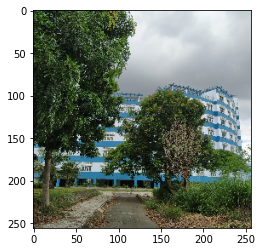

In [66]:
plt.imshow(X[9])

In [67]:
len(y)

1025

#III. Mô tả đặc trưng 

- Trong xử lý ảnh, mỗi pixel sẽ là một đặc trưng của dữ liệu. Bộ dataset là ảnh của những tòa nhà trong UIT. Đối với bộ dataset này thì em sử dụng HOG( histogram of oriented gradients) để trích xuât vector đặc trưng của ảnh.
- Đối với dataset là những tòa nhà thì các vector đặc trưng nhận được vô cùng hữu ích vì nó sẽ trích xuất được các edge features. Đó là sự khác biệt lớn giữa hai pixel lân cận. Khi trích xuất được những đặc trưng này thì model sẽ hoạt động hiệu quả.

##*rút trích đặc trưng

###*feature extraction với histogram of oriented gradient (hog)
- Thư viện sử dụng là skimage

In [48]:
def feature_extraction(img):
    features = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True)
    features=features.ravel()
    return features


In [49]:
def get_feature(data):
    features = []
    for image in data:
        f = feature_extraction(image)
        #f=f/255
        features.append(f)
    return features
    

In [50]:
X_features = get_feature(X)

In [51]:
X_features = np.asarray(X_features)
y = np.asarray(y)

In [52]:
X_features.shape

(779, 34596)

B


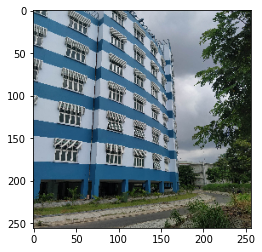

In [53]:
plt.imshow(X[199])
print(y[199])

#** tính chiều dài của features vector:
- pixels_per_cell(x,y): ảnh được chia ra thành các ô có số pixel là x*y
- cells_per_block(x,y): mỗi block chưa x*y ô cells
- orientations : số hướng trong mỗi cell

giả sử chúng ta có ảnh là 64 * 128 ( w * h), orientations = 9, pixels_per_cell(8,8), cells_per_block(3,3)
 
thì với số ô pixel có được là 8 * 16

với 16 ô pixel năm ở trục tung thì ta tính được có 14 vị trí các ô block
và 6 ô vị trí ở trục hoành

với mỗi vị trí thì ta tính được là 9 * 3 * 3 = 81 vector thành phần.

-> chiều dài của features vector : 81 * 14 * 6 = 6804


In [15]:
# from skimage.feature import hog
# from skimage import data, exposure
# image = cv2.imread('/content/dataset/B/IMG_1641.JPG', cv2.IMREAD_GRAYSCALE)
# a, hog_a = feature_extraction(image)
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
# ax1.axis('off')
# ax1.imshow(image, cmap=plt.cm.gray)
# ax1.set_title('Input image')

# # Rescale histogram for better display
# hog_image_rescaled = exposure.rescale_intensity(hog_a, in_range=(0, 10))
# plt.figure(figsize=(8,4))
# ax2.axis('off')
# ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
# ax2.set_title('Histogram of Oriented Gradients')
# #plt.show()

In [16]:
# from skimage.feature import hog
# from skimage import data, exposure
# image = cv2.imread('/content/dataset/B/IMG_1641.JPG', cv2.COLOR_BGR2RGB)
# image = cv2.resize(image, (128,64))
# fd = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3), multichannel=True)
# #plt.imshow(fd)
# fd = np.array(fd)

#** phân chia dataset

In [54]:
from sklearn.model_selection import train_test_split
(X_train, X_test, y_train, y_test) = train_test_split(X_features, y, test_size=0.30, shuffle=True, random_state=42)

#IV. Mô tả thuật toán máy học.

  - Sẽ sử dụng nhiều thuật toán classification khác nhau để có cái nhìn khác nhau về các thuật toán.
  Ví dụ: SVM classification, Decision Tree Classification, ...

  - Độ đo sử dụng là accuracy, precision & recall và confusion matrix

  - Độ đo accuracy sẽ tính dựa trên số sample dự đoán đúng chia cho tổng số sample

  - Độ đo precision & recall đối với multilabels classify thì sẽ được tính :

  - Độ đo confusion matrix sẽ cho thấy được số samples dự đoán đúng của từng lớp và số sample dự đoán sai của mỗi class

  

##*Phân loại với model SVM classification

In [55]:
from sklearn.svm import SVC
SVCClassifier = SVC(C=3.5)
SVCClassifier.fit(X_train, y_train)

SVC(C=3.5, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [56]:
SVCClassifier.score(X_train, y_train)

1.0

In [57]:
SVCClassifier.score(X_test, y_test)

0.8333333333333334

In [58]:
ypred=SVCClassifier.predict(X_test)

In [59]:
from sklearn.metrics import classification_report
print(classification_report(y_test, ypred))

              precision    recall  f1-score   support

           B       0.79      0.89      0.84        81
           C       0.85      0.84      0.85        63
          CT       0.78      0.71      0.74        41
           D       0.93      0.84      0.88        49

    accuracy                           0.83       234
   macro avg       0.84      0.82      0.83       234
weighted avg       0.84      0.83      0.83       234



In [23]:
from joblib import dump
dump(SVCClassifier, 'SVC.joblib')

['SVC.joblib']

##* Linear SVC

In [24]:
from sklearn.svm import LinearSVC

Linear = LinearSVC(C=1.75, multi_class= "ovr")
Linear.fit(X_train, y_train)
LinearPred = Linear.predict(X_test)
print(classification_report(y_test, LinearPred))
#Linear.score(y_test, LinearPred)

              precision    recall  f1-score   support

           B       0.82      0.72      0.77        78
           C       0.76      0.77      0.77        62
          CT       0.79      0.74      0.76        50
           D       0.89      0.89      0.89        53
           E       0.73      0.86      0.79        65

    accuracy                           0.79       308
   macro avg       0.80      0.80      0.79       308
weighted avg       0.80      0.79      0.79       308



/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [25]:
Linear.score(X_test, y_test)

0.7922077922077922

In [26]:
dump(Linear, 'LinearSVC.joblib')

['LinearSVC.joblib']

##* SGDClassifications

In [27]:
from sklearn.linear_model import SGDClassifier

SGD = SGDClassifier()
SGD.fit(X_train, y_train)
SGDpred = SGD.predict(X_test)
print(classification_report(y_test, SGDpred))
SGD.score(X_test, y_test)

              precision    recall  f1-score   support

           B       0.79      0.78      0.79        78
           C       0.78      0.82      0.80        62
          CT       0.86      0.76      0.81        50
           D       0.90      0.89      0.90        53
           E       0.76      0.82      0.79        65

    accuracy                           0.81       308
   macro avg       0.82      0.81      0.82       308
weighted avg       0.81      0.81      0.81       308



0.8116883116883117

In [28]:
dump(SGD, 'SGD.joblib')

['SGD.joblib']

In [29]:
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier()
DTC.fit(X_train, y_train)
DTCpred = DTC.predict(X_test)
print(classification_report(y_test, DTCpred))

              precision    recall  f1-score   support

           B       0.52      0.44      0.47        78
           C       0.28      0.35      0.31        62
          CT       0.16      0.14      0.15        50
           D       0.36      0.38      0.37        53
           E       0.42      0.42      0.42        65

    accuracy                           0.36       308
   macro avg       0.35      0.34      0.34       308
weighted avg       0.36      0.36      0.36       308



#V. Cài đặt, Tinh chỉnh tham số

- Với model SVM thì có một hyperameter là C. Tham số này sẽ quyết định độ nhạy của model. Sẽ cho thấy model có quan tâm đến những outliers nhiều hay ít.

In [ ]:
from sklearn.svm import SVC
def turning(min_ep=1, max_ep=2):
    #r = [x * 0.1 for x in range(10*min_ep, 10*max_ep)]
    r = [0.001, 0.01, 0.1, 0.2, 0.5, 0.7, 0.9, 1.2, 1.8, 2.0]
    mean = []
    mean_test = []
    for i in r:
        cf = SVC(C=i)
        cf.fit(X_train, y_train)  
        mean.append(cf.score(X_test, y_test))
        mean_test.append(cf.score(f_X, testy))
    mean = np.array(mean)
    mean_test = np.array(mean_test)
    r = np.array(r)
    return mean, mean_test, r
      

In [ ]:
mean,mean_test, r = turning(1,2)

In [ ]:
plt.xlabel('Training Episode')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.plot(r,mean, 'b-', label='valid')
plt.plot(r,mean_test ,'r-', label='test')
plt.legend()

#*Xử lý trích xuất features bằng HOG và tăng cường cường độ của features

In [ ]:
img_path = input()
img = Image.open(img_path)
_, hog_img = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True, visualize=True)
hog_image_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10))
f, a = plt.subplots(1,2, figsize=(18,18))
a[0].imshow(hog_img)
a[1].imshow(hog_image_rescaled)  

In [ ]:
def exposure_hog(img):
    ft, hog_img = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True, visualize=True)
    hog_image_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10))
    features = image.img_to_array(hog_image_rescaled)
    return features

In [ ]:
def exposure_features(data):
    features = []
    for image in data:
      f = exposure_hog(image)
      features.append(f)
    return features

In [ ]:
X_hog = exposure_features(X)
X_hog = np.asarray(X_hog)
X_hog.shape

In [ ]:
X_hog = X_hog.reshape(X_hog.shape[0], X_hog.shape[1]*X_hog.shape[2])

In [ ]:
(Xhog_train, Xhog_test, yhog_train, yhog_test) = train_test_split(X_hog, y, test_size=0.25, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split
clf = SVC(C=2.8)
clf.fit(Xhog_train, yhog_train)
print(clf.score(Xhog_test, yhog_test))
yhogpred=clf.predict(Xhog_test)

print(classification_report(yhog_test, yhogpred))

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(yhog_test, yhogpred))

In [ ]:
from sklearn.svm import SVC
def turning(min_ep=1, max_ep=2):
    r = [x * 0.1 for x in range(10*min_ep, 10*max_ep)]
    mean = []
    for i in r:
        cf = SVC(C=i)
        cf.fit(Xhog_train, yhog_train)  
        mean.append(cf.score(Xhog_test, yhog_test))
    mean = np.array(mean)
    r = np.array(r)
    return mean, r
mean, r = turning(1,4)   

In [ ]:
plt.xlabel('Training Episode')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.plot(r,mean, 'b-', label='a')
plt.legend()

In [ ]:
from joblib import dump
dump(clf, 'hogSVC.joblib')

#*Test data

In [31]:
zipfile.ZipFile("/content/drive/My Drive/testdata.zip", 'r').extractall("/content/")

In [60]:
testX, testy = load_images_from_folder('/content/testdata')

In [61]:
f_X = get_feature(testX)
f_X = np.asarray(f_X)
# testX = testX.reshape(testX.shape[0], testX.shape[1]*testX.shape[2])
f_X.shape

(271, 34596)

In [62]:
SGD.score(f_X, testy)

0.6014760147601476

In [68]:
pred = DTC.predict(f_X)
print(DTC.score(f_X, testy))
print(classification_report(testy, pred))
from sklearn.metrics import confusion_matrix
print(confusion_matrix(testy, pred))

0.23616236162361623
              precision    recall  f1-score   support

           B       0.38      0.33      0.35        58
           C       0.28      0.24      0.26        67
          CT       0.27      0.12      0.16        67
           D       0.36      0.27      0.31        79
           E       0.00      0.00      0.00         0

    accuracy                           0.24       271
   macro avg       0.26      0.19      0.22       271
weighted avg       0.32      0.24      0.27       271

[[19 14  2 12 11]
 [14 16  8 14 15]
 [ 5 17  8 11 26]
 [12 11 12 21 23]
 [ 0  0  0  0  0]]


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#*VI. Đánh giá kết quả, kết luật
- Sau khi chạy model trên tập test 331 ảnh thì độ chính xác của model đã bị giảm xuống còn khoảng 60%

- Nhận định: Độ chính xác bị giảm có thể do bộ dữ liệu còn khá ít, 1026 ảnh cho 5 class, mỗi class khoảng 200 ảnh. Do đó model đã chưa có được độ tổng quát.

- Có sự khác biệt giữa ảnh đã huấn luyện và ảnh sử dụng để test về độ sáng, màu sắc bởi vì đã chụp trong 2 ngày khác nhau, thời tiết, độ xác khác nhau nên dẫn đến giảm độ chính xác.

<img src="https://drive.google.com/uc?export=view&id=1VxKpt7Z-MjpqYnVknGvhpKuspEy2fNz9" class="center" width=257 height= 342 />


<img src="https://drive.google.com/uc?export=view&id=1ELwuoptFCLxQSxpOfeI7SylXhCyvFUhJ" class="center" width=257 height= 342 />


- Ảnh hướng bởi cách chụp dataset, vì vị trí của tòa B rất lớn so với khung hình của máy ảnh nên chỉ có thể chụp từng khoảng của nhà B để train. Khi chụp như vậy thì dẫn đến việc nhà B khá tương đồng với nhà E nên đã giảm độ chính xác khi dự đoán nhà B. Có thể thấy trong confusion matrix, nhãn B đã được dự đoán là nhãn E khá nhiều.


<img src="https://drive.google.com/uc?export=view&id=1QY3UHr6gw5pCVpGJpaOEgMrsfvN4GX65" class="center" width=257 height= 342 />

<img src="https://drive.google.com/uc?export=view&id=1GtpArPd8rkAdYYN-wDFjuNPbCQANbT91" class="center" width=257 height= 342 />

- Nhà B

<img src="https://drive.google.com/uc?export=view&id=1ZJ7rNWF_wEjrTgLq-XL0UexgSw41_VXN" class="center" width=257 height= 342 />

<img src="https://drive.google.com/uc?export=view&id=1k1o3rRbSY0cygQ4NyxOMXlawT2QyTs_a" class="center" width=257 height= 342 />

- Nhà E






In [2]:
from joblib import load

In [30]:
clf = load('/content/SGD.joblib')

https://scontent.fsgn1-1.fna.fbcdn.net/v/t31.0-8/15068380_127705937709867_6486249421980889466_o.jpg?_nc_cat=100&_nc_sid=e3f864&_nc_ohc=pthJPRT0D-sAX-_8C8-&_nc_ht=scontent.fsgn1-1.fna&oh=480691af238e38268425c735387b6c5a&oe=5F36669F
SVC ['C']


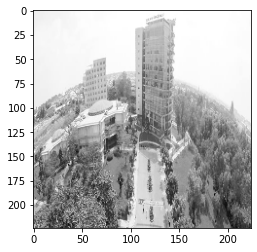

In [ ]:
from PIL import Image
import requests
from io import BytesIO
url = input()
resp = requests.get(url, stream=True).raw
img = np.asarray(bytearray(resp.read()), dtype="uint8")
img = cv2.imdecode(img, cv2.IMREAD_GRAYSCALE)
img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)
#img = cv2.imread(path, cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(224,224))
img = cv2.cvtColor(img,cv2.IMREAD_GRAYSCALE)
plt.imshow(img)
img = feature_extraction(img)
img = img.reshape(1, img.shape[0])
print(clf.__class__.__name__,clf.predict(img))


#** Xử dụng model cho một bức ảnh

In [79]:
def display_hog(img_path):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  _, hog_img = hog(img, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=True, visualize=True)
  hog_image_rescaled = exposure.rescale_intensity(hog_img, in_range=(0, 10))
  f, a = plt.subplots(1,2, figsize=(18,18))
  a[0].imshow(hog_img)
  a[1].imshow(hog_image_rescaled)  

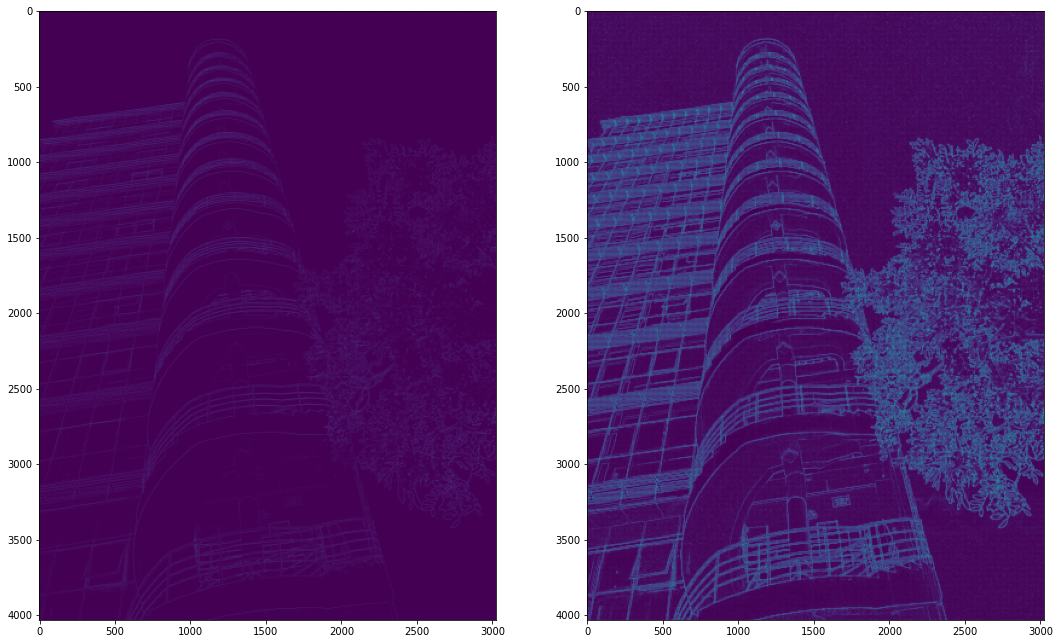

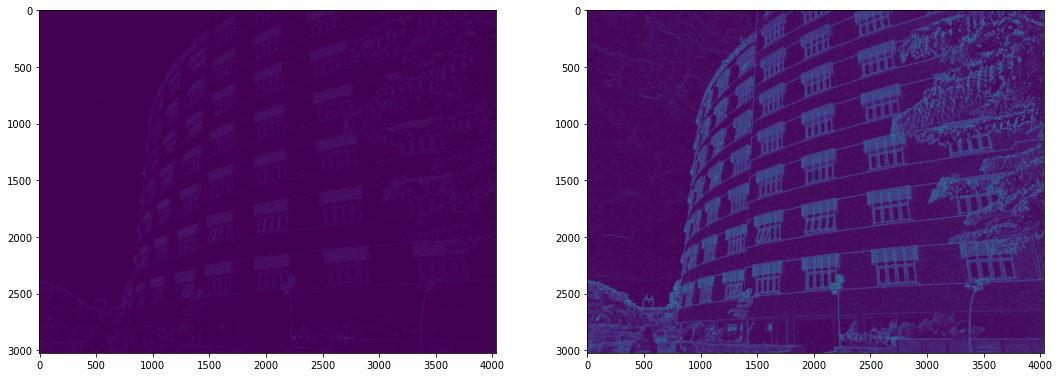

In [81]:
display_hog('/content/testdata/E/IMG_4108.JPG')
display_hog('/content/dataset/B/IMG_1655.JPG')

In [70]:
 
 def predict_one_image(path):
    img = cv2.imread(path, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256,256))
    img = feature_extraction(img)
    #img = img/255
    img = img.reshape(1, img.shape[0])
    return clf.predict(img)

In [76]:
predict_one_image('/content/IMG_4108.jpg')

array(['B'], dtype='<U2')

In [ ]:
import matplotlib.image as mpimg
def pei(path):  
  #path = input()
  img = cv2.imread(path, cv2.COLOR_BGR2GRAY)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.figure()
  plt.imshow(img)
  #for clf in [SVCClassifier, Linear, SGD]:
  print(clf.__class__.__name__,clf.predict(predict_one_image(path)))

In [ ]:
for filename in os.listdir('/content/drive/My Drive/Dataset Đồ án ML/testset/E'):
    pei('/content/drive/My Drive/Dataset Đồ án ML/testset/E'+'/' + filename)

In [ ]:
def pred(img):
    img = cv2.resize(img, (256,256))
    img = feature_extraction(img)
    #img = img/255
    img = img.reshape(1, img.shape[0])
    return img

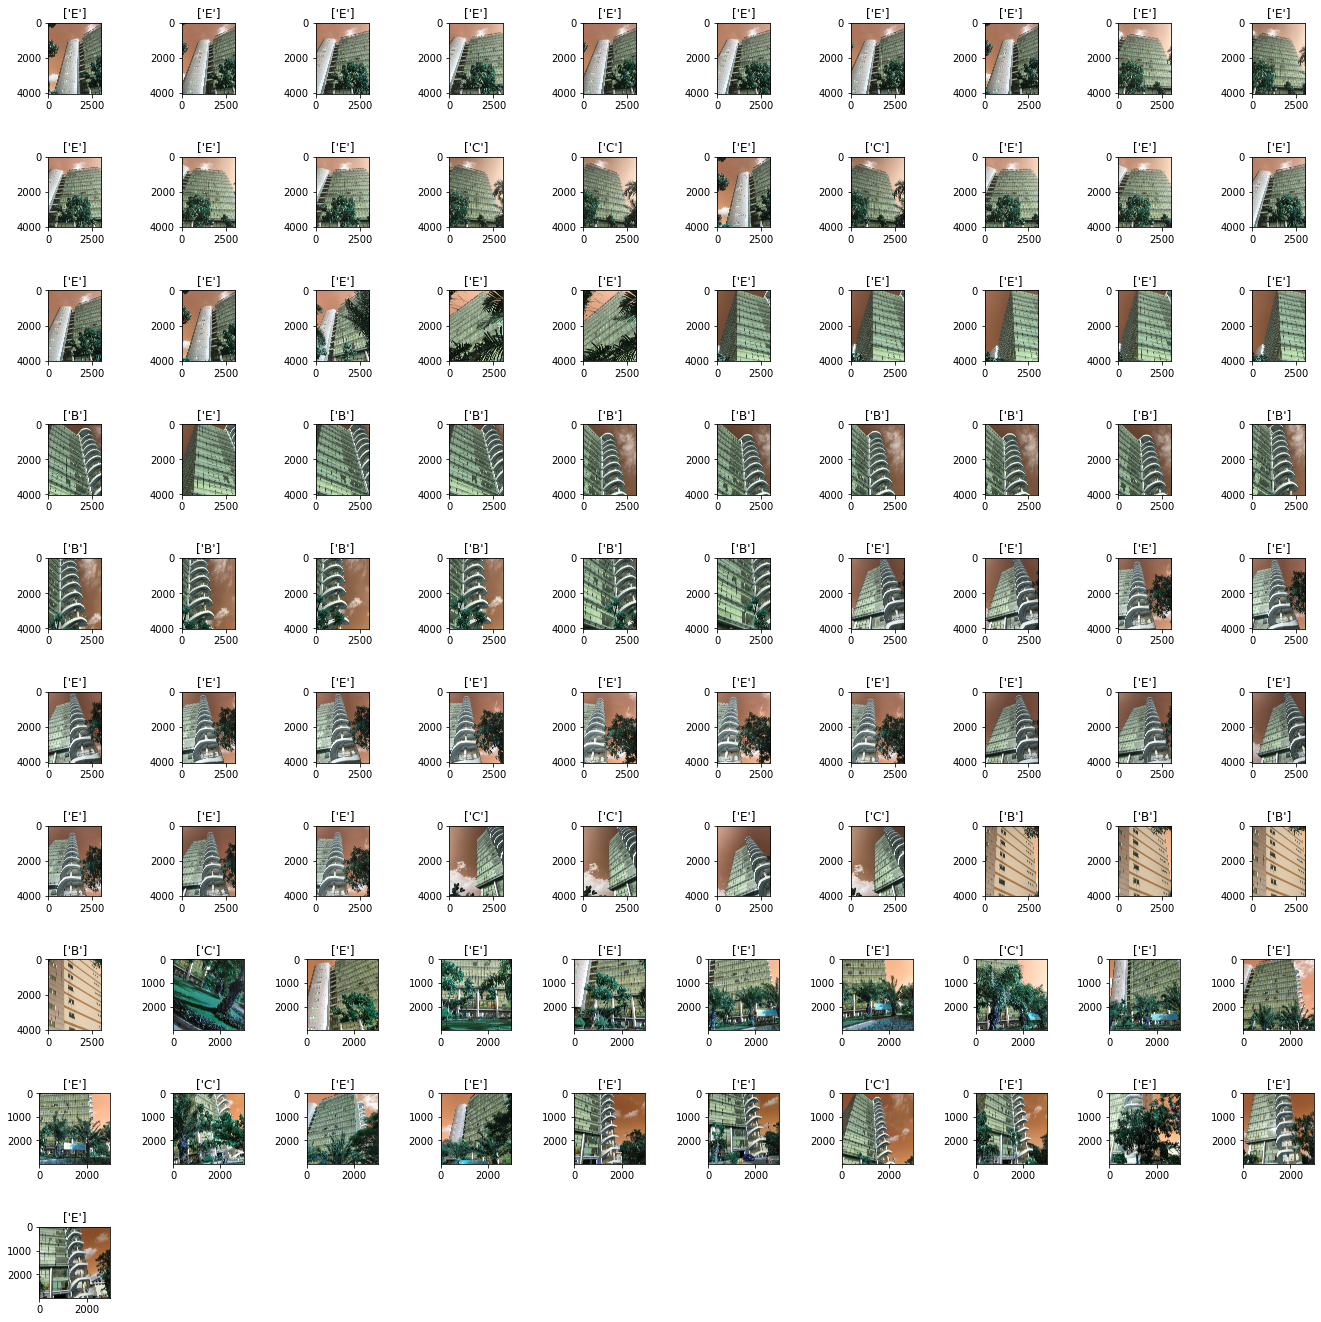

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

w = 10
h = 10
fig = plt.figure(figsize=(19, 19))

columns = 10
rows = 10

# prep (x,y) for extra plotting

# ax enables access to manipulate each of subplots
ax = []
path = []
for filename in os.listdir('/content/drive/My Drive/Dataset Đồ án ML/testset/E'):
    path.append('/content/drive/My Drive/Dataset Đồ án ML/testset/E'+'/'+filename)
for i in range(len(path)):
    # create subplot and append to ax
    img = cv2.imread(path[i])
    ax.append( fig.add_subplot(rows, columns, i+1 ))
    ax[-1].set_title(predict_one_image(path[i]))  # set title
    fig.tight_layout(pad=3.0)
    plt.imshow(img)

# do extra plots on selected axes/subplots
# note: index starts with 0
plt.show()  # finally, render the plot